В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tt

from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
!nvidia-smi

Thu Dec 22 05:36:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    25W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Часть 1. Подготовка данных (1 балл)

Так как старая ссылка на Google Drive с датасетом не работает, загрузим копию датасета [напрямую с Kaggle](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small) (для работы данного кода нужно положить API ключ kaggle.json в одну директорию с данным ноутбуком).

In [5]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tommykamaz/faces-dataset-small

100% 3.99G/3.99G [00:27<00:00, 173MB/s]
100% 3.99G/3.99G [00:27<00:00, 154MB/s]


In [7]:
!mkdir images
!unzip -q -o faces-dataset-small.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

In [8]:
DATA_DIR = './images/'

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
def get_dataloader(image_size, batch_size, device):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """

    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
    return train_ds, DeviceDataLoader(train_dl, device)

In [11]:
image_size = 128
batch_size = 16

train_dataset, train_loader = get_dataloader(image_size, batch_size, device)

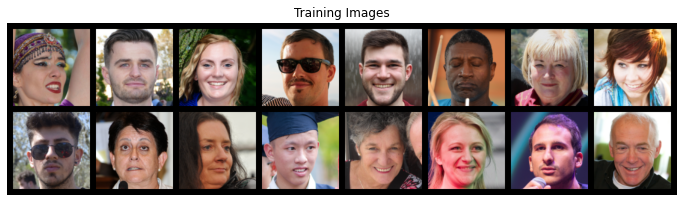

In [12]:
first_batch = next(iter(train_loader))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(make_grid(first_batch[0][:64], padding=10, normalize=True).cpu(), (1, 2, 0)));

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Возьмем за основу DCGAN из [официальной документации PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) 

In [13]:
num_channels = 3
discriminator_feature_maps = 32
generator_feature_maps = 64

In [14]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
discriminator = nn.Sequential(
    # input is num_channels x 128 x 128
    nn.Conv2d(num_channels, discriminator_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. discriminator_feature_maps x 64 x 64
    nn.Conv2d(discriminator_feature_maps, discriminator_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 2),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 2) x 32 x 32
    nn.Conv2d(discriminator_feature_maps * 2, discriminator_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 4),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 4) x 16 x 16
    nn.Conv2d(discriminator_feature_maps * 4, discriminator_feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 8),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 8) x 8 x 8
    nn.Conv2d(discriminator_feature_maps * 8, discriminator_feature_maps * 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(discriminator_feature_maps * 16),
    nn.LeakyReLU(0.2, inplace=True),

    # state size. (discriminator_feature_maps * 16) x 4 x 4
    nn.Conv2d(discriminator_feature_maps * 16, 1, kernel_size=4, stride=1, padding=0, bias=False),

    # state size. 1 x 1 x 1
    nn.Flatten(),
    nn.Sigmoid()
)

In [16]:
discriminator.to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
discriminator.apply(weights_init)

# Print the model
print(discriminator)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [17]:
latent_size = 128

generator = nn.Sequential(
    # input is latent_size, going into a convolution
    nn.ConvTranspose2d(latent_size, generator_feature_maps * 16, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 16),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 16) x 4 x 4
    nn.ConvTranspose2d(generator_feature_maps * 16, generator_feature_maps * 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 8),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 8) x 8 x 8
    nn.ConvTranspose2d(generator_feature_maps * 8, generator_feature_maps * 4, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 4),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 4) x 16 x 16
    nn.ConvTranspose2d(generator_feature_maps * 4, generator_feature_maps * 2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps * 2),
    nn.ReLU(True),

    # state size. (generator_feature_maps * 2) x 32 x 32
    nn.ConvTranspose2d(generator_feature_maps * 2, generator_feature_maps, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(generator_feature_maps),
    nn.ReLU(True),

    # state size. generator_feature_maps x 64 x 64
    nn.ConvTranspose2d(generator_feature_maps, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # state size. num_channels x 64 x 64
)

In [18]:
generator.to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
generator.apply(weights_init)

# Print the model
print(generator)

Sequential(
  (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [19]:
def fit(train_dl, model, optimizer, criterion, epochs):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()
            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch + 1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
    return losses_g, losses_d, real_scores, fake_scores

In [20]:
lr = 0.0002
max_epochs = 50

model = {
    "discriminator": discriminator,
    "generator": generator
}

optimizer = {
    "discriminator": optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

losses_g, losses_d, real_scores, fake_scores = fit(train_loader, model, optimizer, criterion, max_epochs)

  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 14.9638, loss_d: 0.8208, real_score: 0.8542, fake_score: 0.1806


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 8.9921, loss_d: 0.1812, real_score: 0.9372, fake_score: 0.0578


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 6.6951, loss_d: 0.0519, real_score: 0.9780, fake_score: 0.0189


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 6.3098, loss_d: 0.0199, real_score: 0.9905, fake_score: 0.0090


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 8.6070, loss_d: 1.2219, real_score: 0.8539, fake_score: 0.1162


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 5.5832, loss_d: 0.5222, real_score: 0.8539, fake_score: 0.1368


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.5052, loss_d: 0.6814, real_score: 0.8118, fake_score: 0.1858


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 4.3052, loss_d: 0.7107, real_score: 0.8010, fake_score: 0.1998


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 3.8458, loss_d: 0.8808, real_score: 0.7481, fake_score: 0.2472


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 3.7041, loss_d: 0.8180, real_score: 0.7592, fake_score: 0.2399


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 3.5760, loss_d: 0.8530, real_score: 0.7491, fake_score: 0.2552


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.5305, loss_d: 0.8870, real_score: 0.7337, fake_score: 0.2623


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 3.4968, loss_d: 0.8448, real_score: 0.7453, fake_score: 0.2579


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 3.4441, loss_d: 0.9287, real_score: 0.7240, fake_score: 0.2772


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 3.3053, loss_d: 0.8738, real_score: 0.7279, fake_score: 0.2722


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 3.5371, loss_d: 0.8553, real_score: 0.7325, fake_score: 0.2635


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 3.3889, loss_d: 0.8083, real_score: 0.7430, fake_score: 0.2547


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 3.4194, loss_d: 0.7953, real_score: 0.7480, fake_score: 0.2522


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 3.4772, loss_d: 0.7295, real_score: 0.7590, fake_score: 0.2368


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 3.5288, loss_d: 0.7352, real_score: 0.7620, fake_score: 0.2346


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.6565, loss_d: 0.7456, real_score: 0.7624, fake_score: 0.2352


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 3.5991, loss_d: 0.7148, real_score: 0.7658, fake_score: 0.2315


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 3.7963, loss_d: 0.7256, real_score: 0.7678, fake_score: 0.2309


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 3.5009, loss_d: 0.7006, real_score: 0.7711, fake_score: 0.2281


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.4690, loss_d: 0.7311, real_score: 0.7662, fake_score: 0.2315


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 3.4781, loss_d: 0.7185, real_score: 0.7686, fake_score: 0.2290


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 3.2866, loss_d: 0.6815, real_score: 0.7746, fake_score: 0.2232


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.5594, loss_d: 0.6492, real_score: 0.7825, fake_score: 0.2181


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 3.3275, loss_d: 0.6990, real_score: 0.7723, fake_score: 0.2261


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 3.4059, loss_d: 0.7147, real_score: 0.7735, fake_score: 0.2246


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 3.4399, loss_d: 0.6249, real_score: 0.7887, fake_score: 0.2084


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 3.5871, loss_d: 0.6975, real_score: 0.7813, fake_score: 0.2182


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 3.2695, loss_d: 0.6518, real_score: 0.7849, fake_score: 0.2150


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 3.3082, loss_d: 0.6740, real_score: 0.7812, fake_score: 0.2170


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 3.3284, loss_d: 0.5880, real_score: 0.8012, fake_score: 0.2001


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 3.3296, loss_d: 0.6699, real_score: 0.7880, fake_score: 0.2107


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 3.2581, loss_d: 0.6986, real_score: 0.7804, fake_score: 0.2166


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 3.2718, loss_d: 0.5607, real_score: 0.8065, fake_score: 0.1908


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.3660, loss_d: 0.5712, real_score: 0.8079, fake_score: 0.1914


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 3.5180, loss_d: 0.5879, real_score: 0.8097, fake_score: 0.1913


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.2813, loss_d: 0.5245, real_score: 0.8164, fake_score: 0.1826


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 3.6769, loss_d: 0.5770, real_score: 0.8118, fake_score: 0.1897


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 3.3549, loss_d: 0.5092, real_score: 0.8237, fake_score: 0.1719


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 3.3339, loss_d: 0.5717, real_score: 0.8132, fake_score: 0.1870


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 3.5443, loss_d: 0.4997, real_score: 0.8332, fake_score: 0.1651


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 3.5249, loss_d: 0.5426, real_score: 0.8246, fake_score: 0.1739


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 3.7082, loss_d: 0.5262, real_score: 0.8251, fake_score: 0.1768


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.3748, loss_d: 0.4725, real_score: 0.8376, fake_score: 0.1613


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 3.5406, loss_d: 0.5562, real_score: 0.8272, fake_score: 0.1735


  0%|          | 0/197 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 3.5147, loss_d: 0.4439, real_score: 0.8458, fake_score: 0.1516


Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

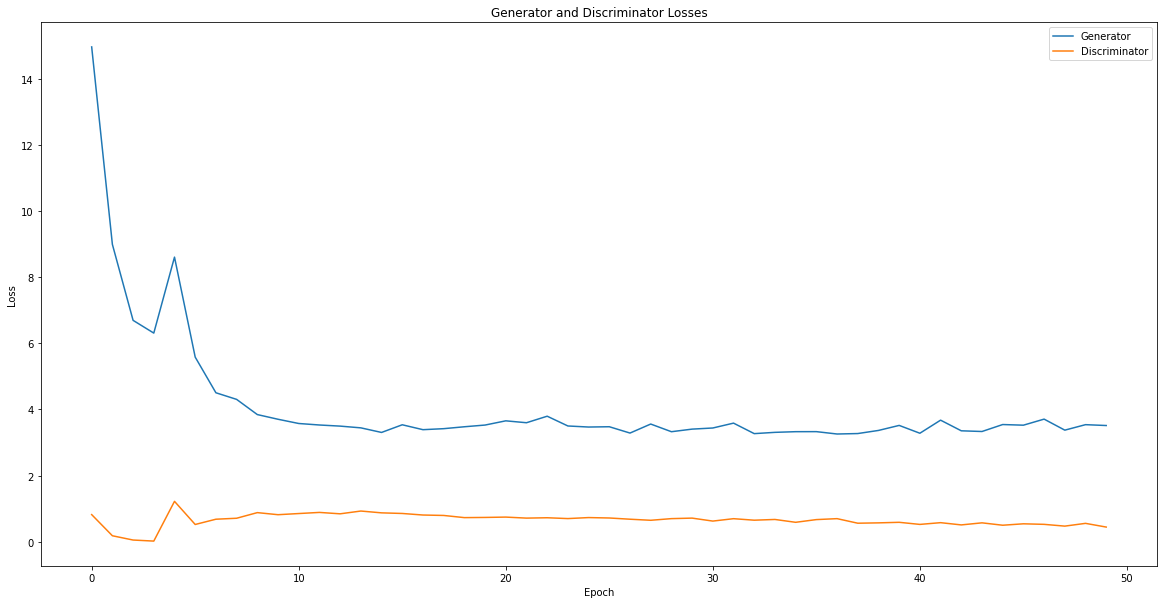

In [31]:
plt.figure(figsize=(20, 10))
plt.title("Generator and Discriminator Losses")
plt.plot(losses_g, label="Generator")
plt.plot(losses_d, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

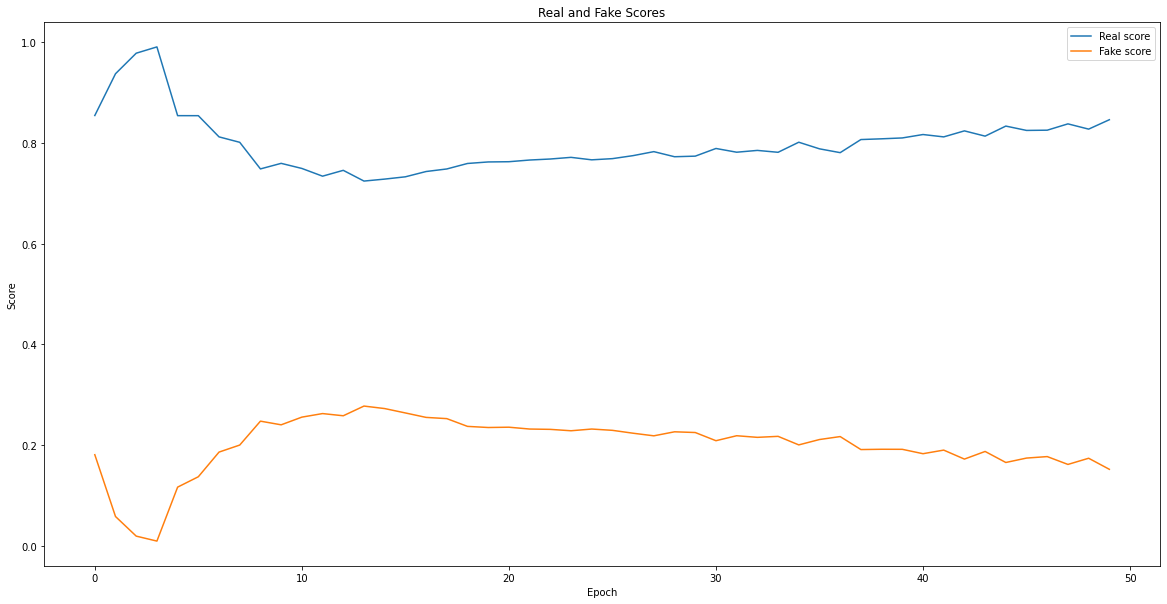

In [39]:
plt.figure(figsize=(20, 10))
plt.title("Real and Fake Scores")
plt.plot(real_scores, label="Real score")
plt.plot(fake_scores, label="Fake score")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()

Поведение графиков аналогично тому, что было показано на лекции и семинаре.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [21]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()

In [22]:
def show_images(generated):
    plt.figure(figsize=(20, 20))
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(make_grid(fake_images, padding=5, normalize=True),(1, 2, 0)))

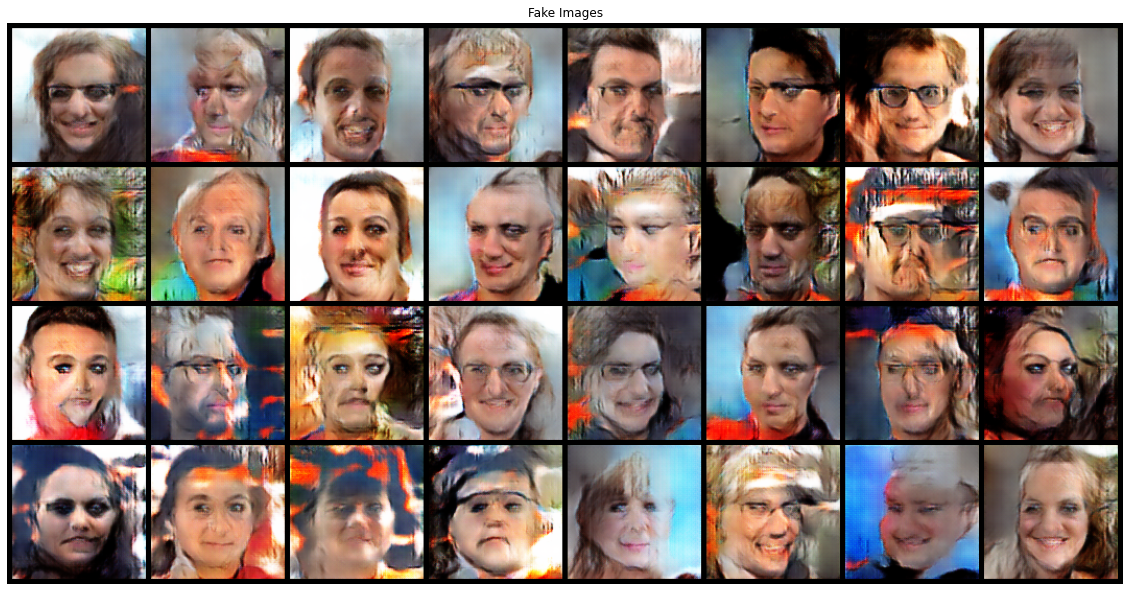

In [23]:
show_images(fake_images)

Как вам качество получившихся изображений?

Модель научилась генерировать основные признаки, составляющие человеческое лицо (глаза, нос, уши, рот, волосы и т. д.). Также модель оказалась способна генерировать лица с различными особенностями (например людей в очках) и лица людей разного пола и возраста. Качество генерации лиц, конечно, далеко от идеального, что могло бы быть исправлено увеличением количества эпох обучения, усложнением архитектуры и, в первую очередь, значительным увеличением обучающей выборки.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [24]:
# на всем датасете LeaveOneOut работает слишком долго, поэтому возьмем небольшую подвыборку
n_images = 500
assert n_images < len(train_dataset)

In [25]:
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)

model["generator"].eval()
with torch.no_grad():
    fake_images = model["generator"](fixed_latent).cpu()

In [27]:
real_images = []
for idx in tqdm(range(n_images)):
    real_images.append(train_dataset[idx][0])

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
fake_images_reshape = fake_images.reshape(fake_images.shape[0], -1)
real_images_reshape = torch.stack(real_images).reshape(fake_images.shape[0], -1)

In [29]:
X = torch.concat([fake_images_reshape, real_images_reshape]).numpy()
y = torch.concat((torch.ones(n_images), torch.zeros(n_images))).numpy()

In [30]:
%%time
cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=1), X, y, cv=LeaveOneOut())
print(f"LOO score: {cv_scores.mean()}")

LOO score: 0.757
CPU times: user 5min 6s, sys: 3min 46s, total: 8min 53s
Wall time: 5min 16s


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Хотелось бы получить accuracy близкий к 0.5, так как это означало бы, что классификатор не может отличить сгенерированные лица от настоящих. В данном случае accuracy > 0.75 говорит о том, что качество генерации далеко от идеала (это видно по сгенерированным изображениям). Стоит, однако, принять во внимание, что вычисления производились на 500 случайных примерах из датасета и на всем датасете картина может измениться.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [33]:
reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Прокомментируйте получившийся результат:

In [38]:
fig = px.scatter(X_reduced, x=0, y=1, color=y.astype(str), labels={'0': 'first-tsne-feature', '1': 'second-tsne-feature'})
fig.show()

Распределения настоящих и фейковых изображений оказались очень похожи в двумерном пространстве, что говорит о правильном направлении обучения модели. Присутствуют отдельные скопления точек одного цвета, говорящих нам о том, что отличия между сгенерированными и реальными лицами все еще существенные (это было видно по предыдущим экспериментам).